# Condition C2VSim Water Level to DWR measured water level data


In [2]:
# First import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skgstat as skg

## Read Water level data
First we will read the DWR water level data. The data have been processed by [this python script](https://ucdavis.app.box.com/file/1451076556615?s=qe43f2t39k9ui8djojwub7gpoweagtlf)

We read all the wells measurements from 2011 - 2023. For each unique well code we calculated the mean, median and slope of the water table trend in ft/year. The dataset includes the number of water level measurmens.

The units of Meadia and Mean are in ft therefore we convert them to meters

In [3]:
WLmeas = pd.read_csv("G:\\Box\\VirtualWells\\SGMAdata\\WellsInCV.csv")
WLmeas.MEDIAN = WLmeas.MEDIAN*0.3048
WLmeas.MEAN = WLmeas.MEAN*0.3048
WLmeas.head()

,Unnamed: 0,X,Y,GSE,RPE,SLOPE,COUNT,MEDIAN,MEAN
0,0,-183587.112005,158172.144408,82.430,84.030,-0.236976,13,22.491192,22.245711
1,1,104862.767240,-303612.799271,514.492,514.492,5.160571,6,25.954330,25.336094
2,2,-113489.158266,-14029.651430,17.210,18.210,0.061719,6,-1.597152,-1.607312
3,3,-96842.210258,9224.974078,117.350,117.350,-0.152069,4,-16.593312,-16.583406
4,4,-37232.652788,-105718.906624,162.720,163.220,-14.827586,5,1.895856,-0.542544


## Filter water level measured data
From the data we will select the wells that have more than 6 water level measurments, which means that there are at leastthreex years of measurments and the slope is less that 1 ft/year

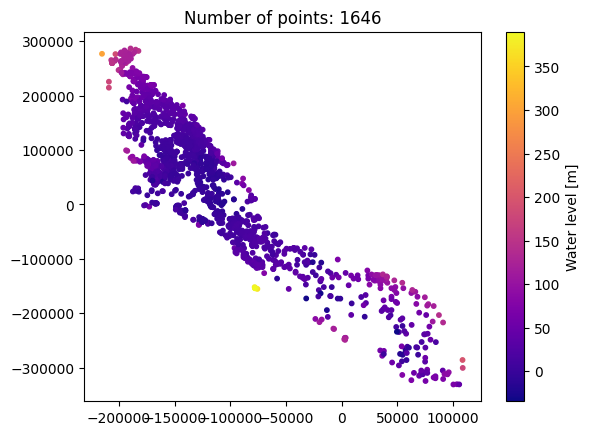

In [4]:
idx = np.where((WLmeas.COUNT > 6) & (abs(WLmeas.SLOPE) < 1))[0]
fig, ax = plt.subplots()
pc = ax.scatter(x=WLmeas.X[idx], y=WLmeas.Y[idx], c = WLmeas.MEDIAN[idx], s = 10, cmap = 'plasma')
ax.set_title("Number of points: %d" %len(idx))
plt.colorbar(pc, ax = ax,label="Water level [m]")
plt.show()

## Create kriging interpolant

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   399998.61
Sill:              3430.55
Nugget:            0.00
        


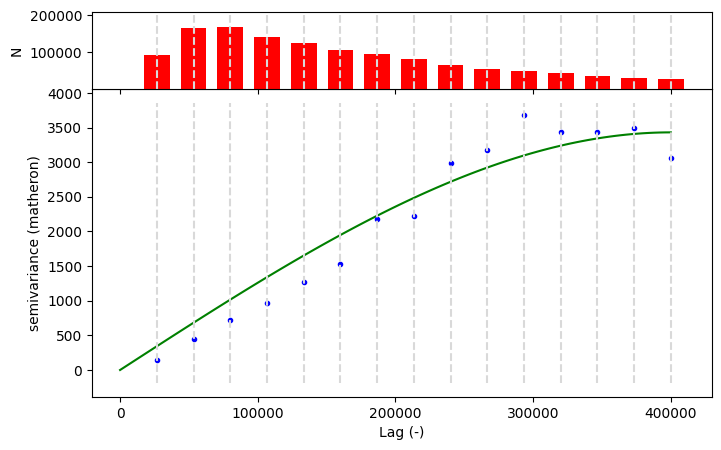

In [5]:
coords = np.column_stack((np.array(WLmeas.X[idx],dtype = np.float64),np.array(WLmeas.Y[idx],dtype = np.float64)))
vals = np.array(WLmeas.MEDIAN[idx],dtype = np.float64)
Vmeas = skg.Variogram(coords, vals, maxlag=400000, n_lags=15, normalize=False, model='Spherical')
fig = Vmeas.plot(show=False)
print(Vmeas)
ok_meas = skg.OrdinaryKriging(Vmeas, min_points=5, max_points=15, mode='exact')

## C2VSim simulated Water level
Read the average simulated water table elevation¶

In [7]:
c2vsim_WL = pd.read_table("G:\\Box\\C2VSim_NPSAT3\\C2VSimAvHeads_00_15.dat",sep =",",header=None,names=['X', 'Y', 'WL'])
c2vsim_WL.head()

,X,Y,WL
0,-199578.797451,293138.759826,174.303675
1,-197579.119727,294527.333982,188.843061
2,-196309.861695,296855.225870,196.970980
3,-194493.016327,298067.904554,201.609427
4,-191730.996721,298016.527936,199.746931


## Calculate a kriging interpolant for the simulated values

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   193007.13
Sill:              2088.13
Nugget:            0.00
        


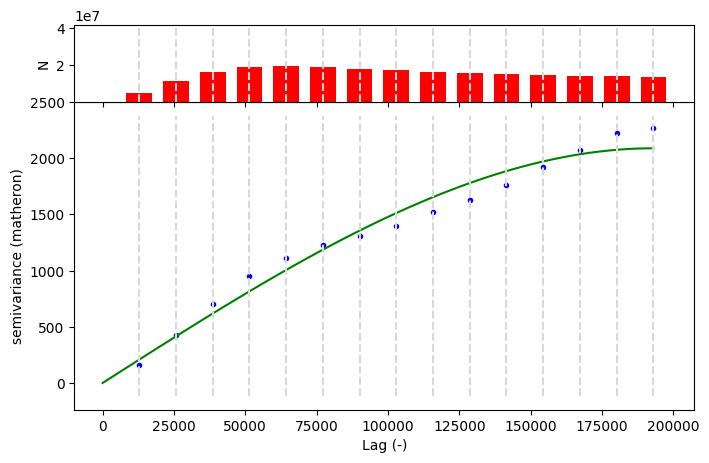

In [9]:
coords_sim = np.column_stack((np.array(c2vsim_WL.X, dtype = np.float64),np.array(c2vsim_WL.Y, dtype = np.float64)))
vals_sim = np.array(c2vsim_WL.WL, dtype = np.float64)
Vsim = skg.Variogram(coords_sim, vals_sim, maxlag='median', n_lags=15, normalize=False, model='Spherical')
fig = Vsim.plot(show=False)
print(Vsim)
ok_sim = skg.OrdinaryKriging(Vsim, min_points=5, max_points=15, mode='exact')

## Condition the Simulated water level to the measured data
1. **Calculate the simulated values on the measured data using the simulated interpolant**

In [12]:
SimValOnWLpnts = ok_sim.transform(WLmeas.X[idx], WLmeas.Y[idx])

Plot the simulated and the measured values on the water level measured points

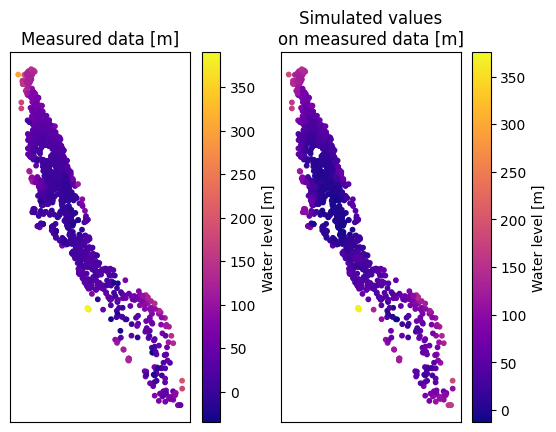

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)
#fig.tight_layout(pad=7.0)
pc1 = ax1.scatter(x=WLmeas.X[idx], y=WLmeas.Y[idx], c = WLmeas.MEDIAN[idx], s = 10, cmap = 'plasma')
pc2 = ax2.scatter(x=WLmeas.X[idx], y=WLmeas.Y[idx], c = SimValOnWLpnts.T, s = 10, cmap = 'plasma')
ax1.set_title("Measured data [m]")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.set_title("Simulated values\non measured data [m]")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
plt.colorbar(pc1, ax = ax1,label="Water level [m]")
plt.colorbar(pc2, ax = ax2,label="Water level [m]")
#plt.subplots_adjust(wspace=1.4)
plt.show()

**2. Build a kriging interpolant using the measured data points with the simulated values**

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   399998.61
Sill:              3235.68
Nugget:            0.00
        


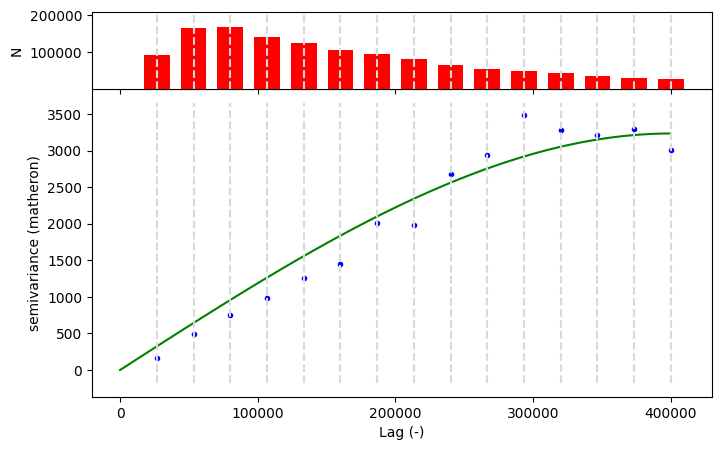

In [15]:
vals_SimonMeas = np.array(SimValOnWLpnts.T, dtype = np.float64)
VsimOnMeas = skg.Variogram(coords, vals_SimonMeas, maxlag=400000, n_lags=15, normalize=False, model='Spherical')
fig = VsimOnMeas.plot(show=False)
print(VsimOnMeas)
ok_SimOnmeas = skg.OrdinaryKriging(VsimOnMeas, min_points=5, max_points=15, mode='exact')

**3. Use the previous interpolant to calculate Simulated values on the simulation points**

In [17]:
SimValOnSimpnts = ok_SimOnmeas.transform(c2vsim_WL.X, c2vsim_WL.Y)

In [19]:
interpError = c2vsim_WL.WL - SimValOnSimpnts.T

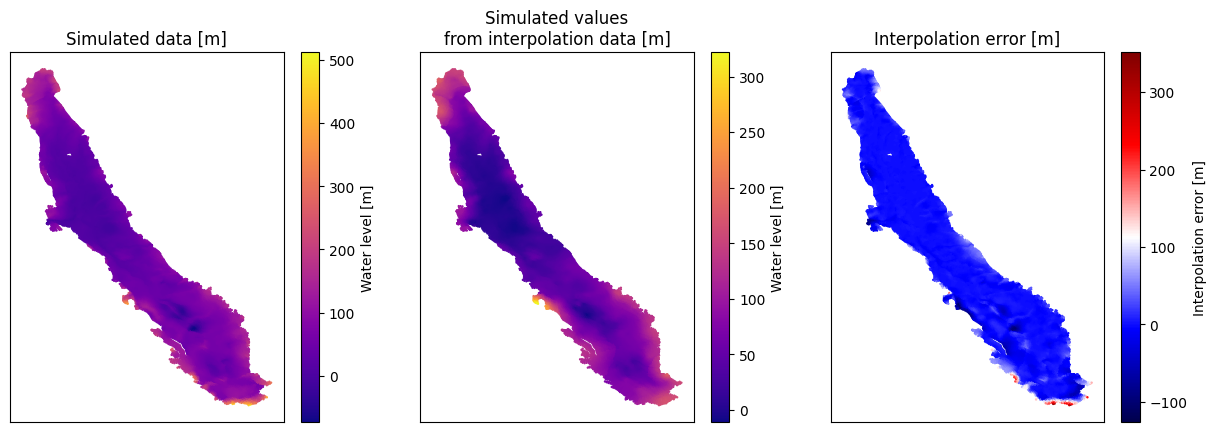

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(15)
#fig.tight_layout(pad=7.0)
pc1 = ax1.scatter(x=c2vsim_WL.X, y=c2vsim_WL.Y, c = c2vsim_WL.WL, s = .5, cmap = 'plasma')
pc2 = ax2.scatter(x=c2vsim_WL.X, y=c2vsim_WL.Y, c = SimValOnSimpnts.T, s = .5, cmap = 'plasma')
pc3 = ax3.scatter(x=c2vsim_WL.X, y=c2vsim_WL.Y, c = interpError, s = .5, cmap = 'seismic')
ax1.set_title("Simulated data [m]")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.set_title("Simulated values\nfrom interpolation data [m]")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.set_title("Interpolation error [m]")
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
plt.colorbar(pc1, ax = ax1,label="Water level [m]")
plt.colorbar(pc2, ax = ax2,label="Water level [m]")
plt.colorbar(pc3, ax = ax3,label="Interpolation error [m]")
#plt.subplots_adjust(wspace=1.4)

plt.show()

**5. Interpolate the Water level data onto the simulated points**

In [21]:
WLonSim = ok_meas.transform(c2vsim_WL.X, c2vsim_WL.Y)

In [22]:
WL_Conditioned = WLonSim + interpError

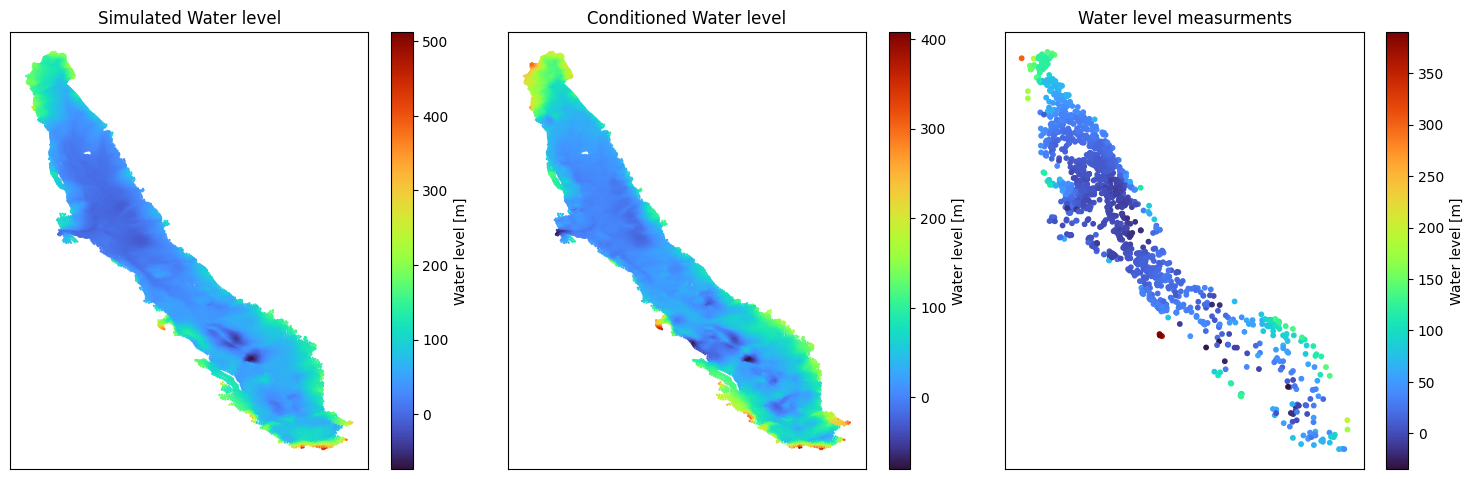

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(15)
fig.tight_layout(pad=0.5)
pc1 = ax1.scatter(x=c2vsim_WL.X, y=c2vsim_WL.Y, c = c2vsim_WL.WL, s = 0.5, cmap = 'turbo')
plt.colorbar(pc1, ax = ax1, label="Water level [m]")
ax1.set_title("Simulated Water level")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

pc2 = ax2.scatter(x=c2vsim_WL.X, y=c2vsim_WL.Y, c = WL_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc2, ax = ax2, label="Water level [m]")
ax2.set_title("Conditioned Water level")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

pc3 = ax3.scatter(x=WLmeas.X[idx], y=WLmeas.Y[idx], c = WLmeas.MEDIAN[idx], s = 10, cmap = 'turbo')
plt.colorbar(pc3, ax = ax3, label="Water level [m]")
ax3.set_title("Water level measurments")
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
plt.show()

In [24]:
# Write the interpolation outcome to a table
np.savetxt('G:\\Box\\C2VSim_NPSAT3\\WL_Krig_00_15.dat',list(zip(c2vsim_WL.X, c2vsim_WL.Y, WL_Conditioned)))